In [1]:
%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
from IPython.utils import io
SHOW_GIFS = False

Notebook available in [PatrikValkovic/ParticleSwarmOptimization](https://github.com/PatrikValkovic/ParticleSwarmOptimization) Github repository.

Can access online (including gifs) at [https://patrikvalkovic.github.io/ParticleSwarmOptimization/main.html](https://patrikvalkovic.github.io/ParticleSwarmOptimization/main.html).

# History

The fathers of the Particle Swarm Optimization technique are considered James Kennedy and Russel Eberhart, who present them in their paper "Particle Swarm Optimization" in 1995 [[1]]([#Bibliography]). Authors take inspiration in nature, concretely in bird flocking and fish schooling and in their simulations already implemented at that time. We can see the behaviors in the videos below.

In [2]:
display.YouTubeVideo('0dskCpuxqtI?start=8', 560, 315)

In [3]:
display.YouTubeVideo('Y-5ffl5_7AI?start=90', 560, 315)

If you play watch through the second video, you can see one of the attempt to fully understand how the fish schooling really behaves by tracking each fish. Although not very important to us, I think it's still interesting.

Let's return to the topic. As scientists found out, the behavior of swarms is most of the time based on very simple rules but executed in a distributed manner. For example, when fish in the swarm see food, it will swim toward it. Otherwise, the fish keeps the same direction as its neighbors. As some wish change their direction toward the food, the rest of the swarm would follow them. As a result, the whole swarm reaches the food, and, in case there is no competition between individuals (enough food for each one), each fish feed itself.

Although there is no explicit communication, the simple rules provide simple information sharing ability inside the flock, increasing the total gain of the group as a whole.

The authors of the paper tried some approaches both to optimize the given function and to simulate flock most "lifely". I will start simple and improve the idea further.

# Particles

In [4]:
import os
import functools
import numpy as np
import matplotlib.pylab as plt
import cocoex
from PIL import Image

import functions as fn
import execution as exe
import plotting as plot
import inspect
import strategies
import utils

First of all, we will have a set of particles scattered over the parameter space. We can, for example, let them move randomly around.

In [5]:
definition = inspect.getsource(strategies.random_walk)
display.display(display.Markdown(f'```python\n{definition}\n```'))

```python
def random_walk(particles: np.ndarray, *vars, stepsize: float = 0.2) -> np.ndarray:
    particles = particles  + np.random.normal(0, stepsize, particles.shape)
    return np.maximum(-5, np.minimum(5, particles))

```

100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 864x576 with 0 Axes>

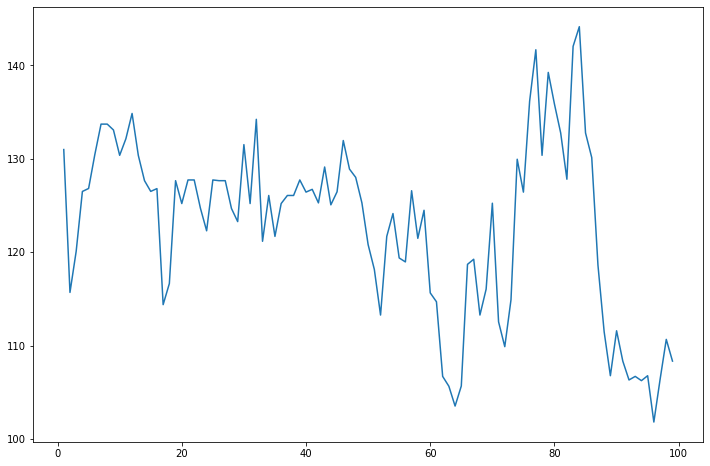

In [6]:
with fn.get_suite_wrapper(dimension=[2], function_indices=[7]) as suite:
    for function in suite:
        populations, values = exe.execute(function, strategies.random_walk, show_progress=True)

        plt.figure(figsize=(12,8))
        plot.plot_graph(values, plot.popfn_median())
        plt.show()

        if SHOW_GIFS:
            gif = plot.animate_movement(function, populations, show_progress=True)
            with open(os.path.join("main", "001.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/001.gif)")

In Particle Swarm Optimization, the positions are not updated directly. Instead, we assign each particle a velocity. Each iteration, we modify the velocity and let the velocity determine the next position. Again, we may initialize the velocity uniformly and then update it randomly each iteration. Formally, the position is updated as

$$
p_i(t+1) = p_t(t) + v_i(t+1)
$$

Velocity update is what differs between approaches. In the previous case (with only random walks) the update is

$$
v_i(t+1) = v_t(t) + N(0, \text{stepsize})
$$

Note that the velocity is the main reason why we call the individuals particles, as velocity is usually connected with something with mass. Otherwise, we could call them just points or dots.

In [7]:
definition = inspect.getsource(strategies.RandomVelocity)
display.display(display.Markdown(f'```python\n{definition}\n```'))

```python
class RandomVelocity:
    def __init__(self, lowerbound, upperbound, populationsize, dimension, velocity_lowerbound, velocity_upperbound):
        self.particles = np.random.uniform(lowerbound, upperbound, (populationsize, dimension))
        self.velocities = np.random.uniform(velocity_lowerbound, velocity_upperbound, (populationsize, dimension))
    def numpy(self):
        return self.particles
    def execute(self, *vars, w: float = 1.0, stepsize: float = 0.05):
        self.velocities = w * self.velocities + np.random.normal(0, stepsize, self.velocities.shape)
        self.particles = np.maximum(-5, np.minimum(5, self.particles + self.velocities))
        return self
    @staticmethod
    def init(lowerbound, upperbound, shape, velocity_lowerbound=0.1, velocity_upperbound=0.1):
        return RandomVelocity(lowerbound, upperbound, shape[0], shape[1], velocity_lowerbound, velocity_upperbound)

```

100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 864x576 with 0 Axes>

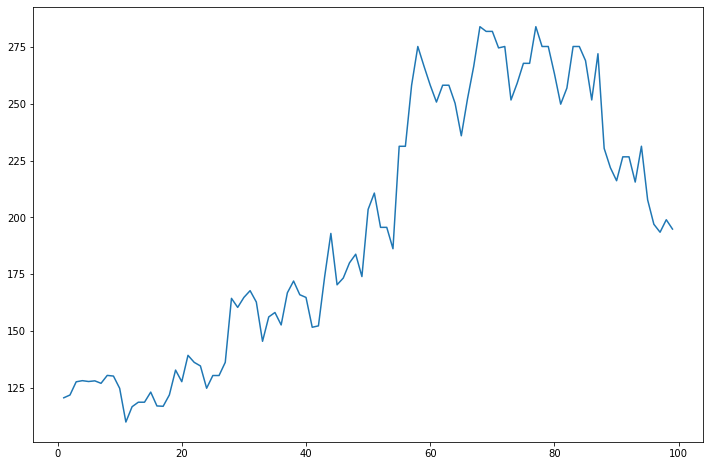

In [8]:
with fn.get_suite_wrapper(dimension=[2], function_indices=[7]) as suite:
    for function in suite:
        populations, values = exe.execute(
            function,
            strategies.RandomVelocity.execute,
            initialization = strategies.RandomVelocity.init,
            show_progress=True)

        plt.figure(figsize=(12,8))
        plot.plot_graph(values, plot.popfn_median())
        plt.show()

        if SHOW_GIFS:
            gif = plot.animate_movement(function, populations, show_progress=True)
            with open(os.path.join("main", "002.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/002.gif)")

Note how the particles end up on edge. Although I limit the positions, so all particles stay within the area, it is not reflected in the velocity update. I will deal with it right away.

What is usually done is to decrease velocity a little bit every iteration, so the velocity can't "explode" too much. The parameter $w$ (sometimes called "inertia weight")  is there exactly for that purpose. We may set it to value between $(0.0, 1.0)$ to decrease velocity every step. As we will see, proposed constant by the paper is $w = \frac{1}{2 \cdot log(2)} \approx 0.721$.

100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 864x576 with 0 Axes>

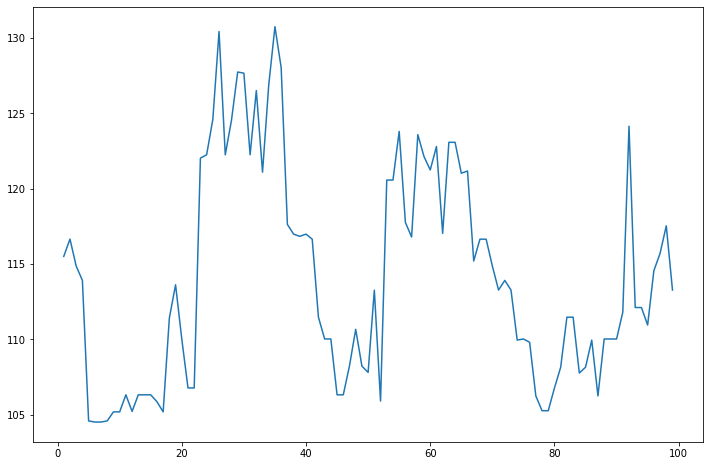

In [9]:
with fn.get_suite_wrapper(dimension=[2], function_indices=[7]) as suite:
    for function in suite:
        populations, values = exe.execute(
            function,
            functools.partial(strategies.RandomVelocity.execute, w=1/(2*np.log(2))),
            initialization = strategies.RandomVelocity.init,
            show_progress=True)

        plt.figure(figsize=(12,8))
        plot.plot_graph(values, plot.popfn_median())
        plt.show()

        if SHOW_GIFS:
            gif = plot.animate_movement(function, populations, show_progress=True)
            with open(os.path.join("main", "003.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/003.gif)")

# Comparison - differential evolution

Previous two examples were great to show the main principles, however, the results were not very satisfying. I wanted some algorithm that I could compare algorithms with. I choose Differential evolution [[2]](#Bibliography), which was published around the same time (1996) and thus is a good candidate for comparison. Moreover, from my experience, differential evolution works quiet well for continuous optimization.

In the differential evolution, new individuals are based on the following formula.
$$
m_n = \text{Uniform}(p_3, p_0 + F \cdot (p_1 - p_2), CR)
$$

Terms $p_0, \dots, p_3$ are parents. Firstly, the algorithm adds a difference of two parents and then performs uniform mutation with probability $1 - CR$. Moreover, I used parental tournament selection to pick up parents for the next iteration.

In [10]:
definition = inspect.getsource(strategies.differential_evolution)
display.display(display.Markdown(f'```python\n{definition}\n```'))

```python
def differential_evolution(population: np.ndarray, fitnesses: np.ndarray, function:cocoex.Problem,
                           parents_fraction: float = 0.6,
                           F: float = 0.8,
                           CR: float = 0.4,
                           ) -> np.ndarray:
    # pickup parents
    num_parents = int(len(population) * parents_fraction)
    parents_tournament_indices = np.random.randint(0, len(population), [2, num_parents])
    comparison = fitnesses[parents_tournament_indices[0]] < fitnesses[parents_tournament_indices[1]]
    better = np.concatenate([
        parents_tournament_indices[0, comparison],
        parents_tournament_indices[1, np.logical_not(comparison)]
    ])
    parents = population[better]

    # create children
    num_children = len(population) - num_parents
    picked_parents = np.random.randint(0, num_parents, [4, num_children])
    crossover_sample = np.random.random([num_children, function.dimension]) > CR
    mutated = parents[picked_parents[0], :] + F * (parents[picked_parents[1]] - parents[picked_parents[2]])
    mutated[crossover_sample] = parents[picked_parents[3]][crossover_sample]
    mutated = np.maximum(-5, np.minimum(5, mutated))

    return np.concatenate([
        parents,
        mutated
    ])

```

100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Function f07 2D using differential evolution')

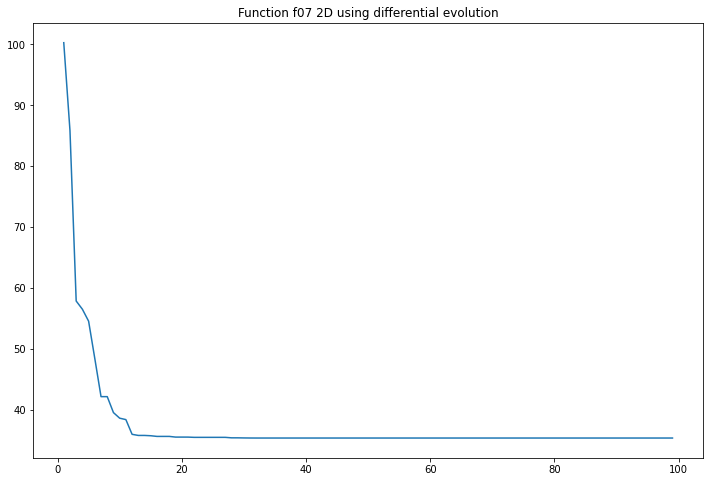

Found best solution
Best evaluation: 35.35000000000368


100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Function f07 5D using differential evolution')

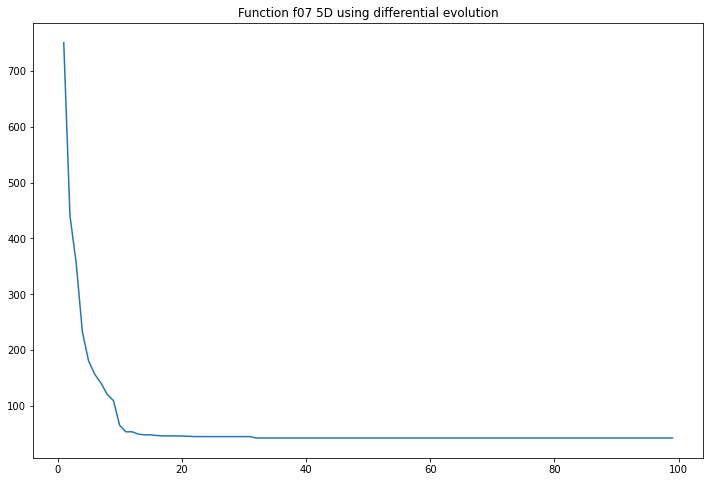

Not found best solution
Best evaluation: 42.54039169908191


In [11]:
with fn.get_suite_wrapper(dimension=[2, 5], function_indices=[7]) as suite:
    for function in suite:  # type: cocoex.Problem
        populations, values = exe.execute(
            function,
            strategies.differential_evolution,
            show_progress=True)

        plt.figure(figsize=(12,8))
        plot.plot_graph(values, plot.popfn_median())
        plt.title(f"Function f07 {function.dimension}D using differential evolution")
        plt.show()

        if SHOW_GIFS and function.dimension == 2:
            gif = plot.animate_movement(function, populations, show_progress=True)
            with open(os.path.join("main", "004.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/004.gif)")


        print(('Found' if function.final_target_hit else 'Not found') + " best solution", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)

As we can see, the algorithm is already doing something and although it doesn't find the optimal solution (that is $35.35$), it wasn't far away (the BBOB framework accepts solution around $10^{-9}$ of optimum). From now on, I will compare the rest of the algorithms to this implementation of the differential strategy.

# Taking best particle into account

In order to perform some optimization, we need to guide the particles somehow. The simplest approach is to pick up the best particle $b$ and move all other particles toward it. However, the particles shoudn't be fully deterministic. Therefore, I will introduce random weight to this direction, sampled randomly from uniform distribution between $0$ and $c$. Again, $c$ proposed by the paper is $c=0.5 + log(2) \approx 1.193$, so i will stick to this value. Formally, the weight update is

$$
v_i = w \cdot v_t + \text{Unif}(0,c)\cdot(b - p_i) + N(0, \textit{stepsize})
$$

We can think about the best particle in a swarm as about some swarm knowledge that the swarm has about the problem.

In [12]:
definition = inspect.getsource(strategies.FollowBest)
display.display(display.Markdown(f'```python\n{definition}\n```'))

```python
class FollowBest:
    def __init__(self, lowerbound, upperbound, populationsize, dimension, velocity_lowerbound, velocity_upperbound):
        self.particles = np.random.uniform(lowerbound, upperbound, (populationsize, dimension))
        self.velocities = np.random.uniform(velocity_lowerbound, velocity_upperbound, (populationsize, dimension))
    def numpy(self):
        return self.particles
    def execute(self, values, *vars, w = 1 / (2 * np.log(2)), c = 0.5 + np.log(2), stepsize = 0.05):
        best = np.argmin(values)
        best_individual = self.particles[best]
        random_walk = np.random.normal(0, stepsize, self.velocities.shape)
        follow_best = np.random.uniform(0, c, len(self.particles))[:,np.newaxis] * (best_individual - self.particles)
        self.velocities = w * self.velocities + random_walk + follow_best
        self.particles = np.maximum(-5, np.minimum(5, self.particles + self.velocities))
        return self
    @staticmethod
    def init(lowerbound, upperbound, shape, velocity_lowerbound=0.1, velocity_upperbound=0.1):
        return FollowBest(lowerbound, upperbound, shape[0], shape[1], velocity_lowerbound, velocity_upperbound)

```

100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Found best solution
Best evaluation: 35.35000000009476


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f7 instance 2 in 2D')

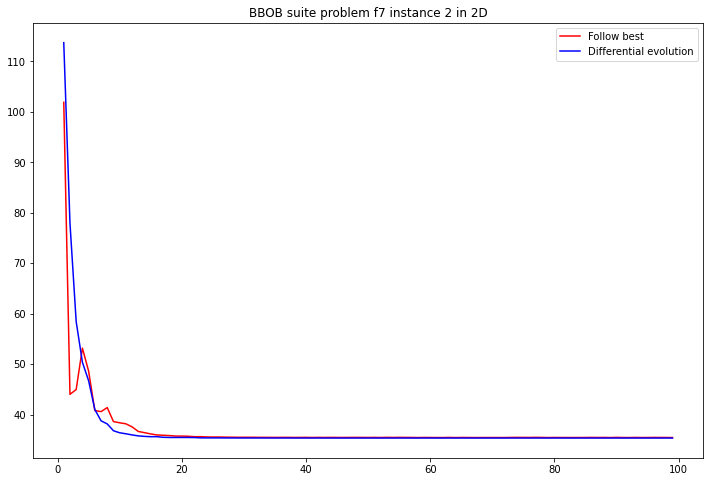

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution
Best evaluation: 35.35000006096605


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f7 instance 2 in 5D')

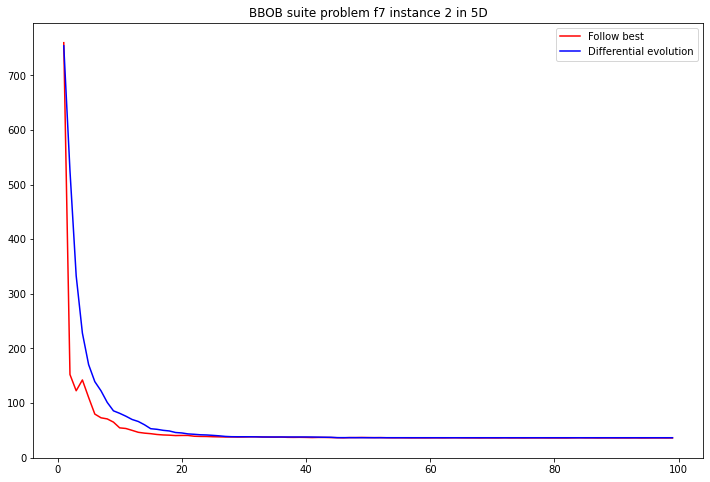

In [13]:
with fn.get_suite_wrapper(dimension=[2, 5], function_indices=[7]) as suite:
    for function in suite:  # type: cocoex.Problem
        populations, values = exe.execute_multiple(
            function,
            strategies.FollowBest.execute,
            initialization=strategies.FollowBest.init,
            show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)
        eva_population, eva_values = exe.execute_multiple(function,strategies.differential_evolution)

        plt.figure(figsize=(12,8))
        plt.title(function.name)
        plot.plot_aggregated(values, plot.popfn_median(), plot.aggfn_median(), label="Follow best", c='r')
        plot.plot_aggregated(eva_values, plot.popfn_median(), plot.aggfn_median(), label="Differential evolution", c='b')
        plt.legend()
        plt.show()

        if SHOW_GIFS and function.dimension == 2:
            gif = plot.animate_movement(function, populations[0], show_progress=True)
            with open(os.path.join("main", "005.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/005.gif)")

The approach has one major drawback. Because all the particles are attracted by the best one, they are all moving to the same position. That can easily cause stick in the local optima, as the best particle doesn't need to be close to the global one. It is easy to demonstrate using function with many local optima - for example `f24`.

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution
Best evaluation: 93.39154367067785


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f24 instance 2 in 2D')

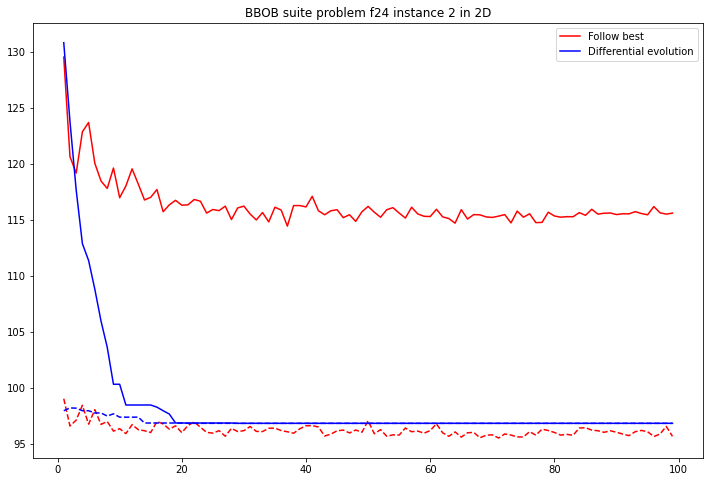

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution
Best evaluation: 103.92126916825832


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f24 instance 2 in 5D')

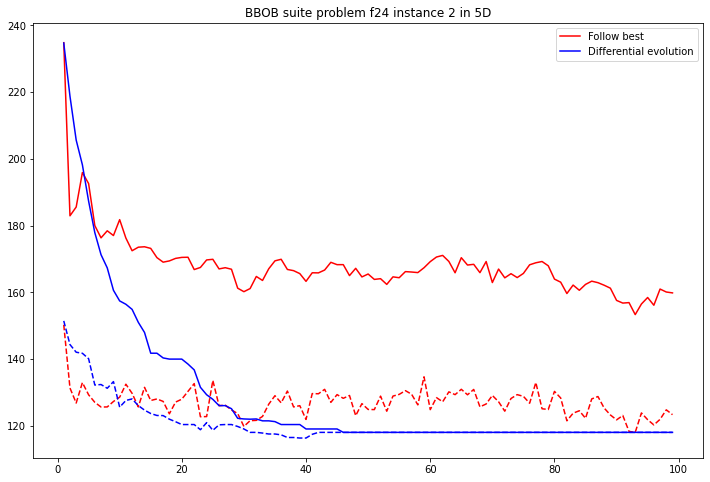

In [14]:
with fn.get_suite_wrapper(dimension=[2, 5], function_indices=[24]) as suite:
    for function in suite:  # type: cocoex.Problem
        populations, values = exe.execute_multiple(
            function,
            strategies.FollowBest.execute,
            initialization=strategies.FollowBest.init,
            show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)
        eva_population, eva_values = exe.execute_multiple(function,strategies.differential_evolution)

        plt.figure(figsize=(12,8))
        plt.title(function.name)
        plot.plot_aggregated(values, plot.popfn_median(), plot.aggfn_median(), label="Follow best", c='r')
        plot.plot_aggregated(values, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='r')
        plot.plot_aggregated(eva_values, plot.popfn_median(), plot.aggfn_median(), label="Differential evolution", c='b')
        plot.plot_aggregated(eva_values, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='b')
        plt.legend()
        plt.show()

        if SHOW_GIFS and function.dimension == 2:
            gif = plot.animate_movement(function, populations[0], show_progress=True)
            with open(os.path.join("main", "006.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/006.gif)")

Depending on the run, particles get stuck around $\left[2,-2\right]$ or $\left[-4, 4\right]$.In any case, they never converge and are moving around chaotically (that can be caused by the random movement as well). This can be seen from the plots as well, as the differential evolution is in order of magnitude better.

On the other hand, late convergence allows particles to evolve over the whole time, compared to the differential evolution, which reached value around $97$ (for `f07`) respectively $117$ (for `f24`) and get stucked there.

# Neighborhood

This reasoning led to introduce neighborhoods. Instead of following the best particle from the whole swarm, each particle has some neighbors, with which it compares its value. The definition of the neighborhood (sometimes called topology) is not defined precisely, and there are many approaches.

Firstly, the topology may change after each iteration or may remain static the whole time. In the first approach, each particle will eventually obtain information from all other particles - and thus can compare their value with all the particles. Constant $K$ denotes how many particles to inform each iteration and was set to $K=3$ in the paper. Because $K$ is quite small, the problem is getting stuck in the local optimum is significantly reduced. In the second approach, the particle doesn't know about the rest of the search space, unless some of it's neighbor reach it. This prevents swarm to stuck in the local optima but reduce the amount of information each particle obtains a lot.

Next, we need to decide how the topology would look like. The first (and deterministic) approach proposed by the paper was called "ring topology". When we index particles, the ring topology for particle $i$ is $\left\{i+1\ mod(N), i+2\ mod(N), \dots, i+K\ mod(N)\right\}$ where $N$ is number of particles. Another proposition was "adaptive random topology", where each particle picks three other particles at random and inform them about its value (note that this topology in its static version is same as the previous one). Another topology is "von Neumann", that you can see below (I will not discuss it here anymore, as it is just modification of the ring topology). Finally, we may simply use $K$ nearest neighbors and inform them (or take information from them).

<a href="https://www.researchgate.net/figure/von-Neumann-neighborhood-structure-for-PSO_fig3_220742792"><img src="https://www.researchgate.net/profile/Enrique_Villa_Diharce/publication/220742792/figure/fig3/AS:472200114380802@1489592688251/von-Neumann-neighborhood-structure-for-PSO.png" alt="von Neumann neighborhood structure for PSO"/></a>

<center>Figure 3: von Neumann neighborhood structure for PSO <a href="#Bibliography">[3]</a></center>

I will show all the topologies and compare them. Let's start with the ring topology.

In [15]:
definition = inspect.getsource(strategies.RingTopology)
display.display(display.Markdown(f'```python\n{definition}\n```'))

```python
class RingTopology:
    def __init__(self, lowerbound, upperbound, populationsize, dimension, velocity_lowerbound, velocity_upperbound):
        self.particles = np.random.uniform(lowerbound, upperbound, (populationsize, dimension))
        self.velocities = np.random.uniform(velocity_lowerbound, velocity_upperbound, (populationsize, dimension))
    def numpy(self):
        return self.particles
    def execute(self, values, *vars, w = 1 / (2 * np.log(2)), c = 0.5 + np.log(2), stepsize = 0.05, K=3):
        N = len(self.particles)
        neighbors = np.linspace(list(range(1,1+K)), list(range(N,N+K)), N, dtype=int) % N
        best_neighbor_indices = (np.arange(1,N+1) + np.argmin(values[neighbors], axis=1)) % N
        best_neighbor = self.particles[best_neighbor_indices]
        random_walk = np.random.normal(0, stepsize, self.velocities.shape)
        follow_best = np.random.uniform(0, c, len(self.particles))[:,np.newaxis] * (best_neighbor - self.particles)
        self.velocities = w * self.velocities + random_walk + follow_best
        self.particles = np.maximum(-5, np.minimum(5, self.particles + self.velocities))
        return self
    @staticmethod
    def init(lowerbound, upperbound, shape, velocity_lowerbound=0.1, velocity_upperbound=0.1):
        return RingTopology(lowerbound, upperbound, shape[0], shape[1], velocity_lowerbound, velocity_upperbound)

```

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution
Best evaluation: 35.35000005078283


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Function f07 2 using ring topology')

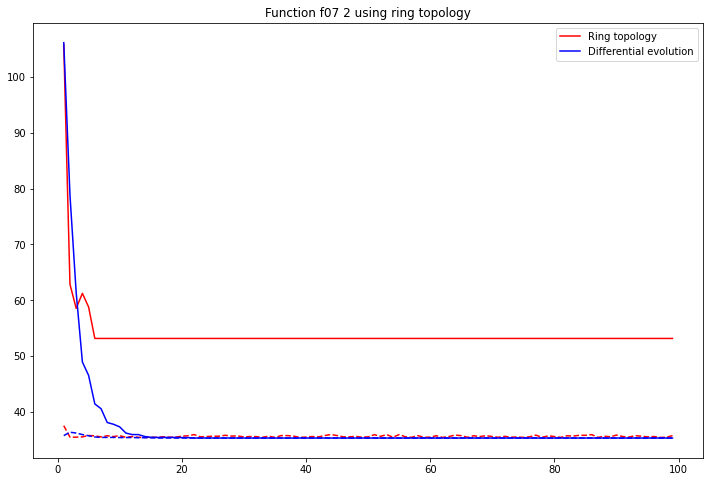

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution
Best evaluation: 36.01348425309234


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Function f07 5 using ring topology')

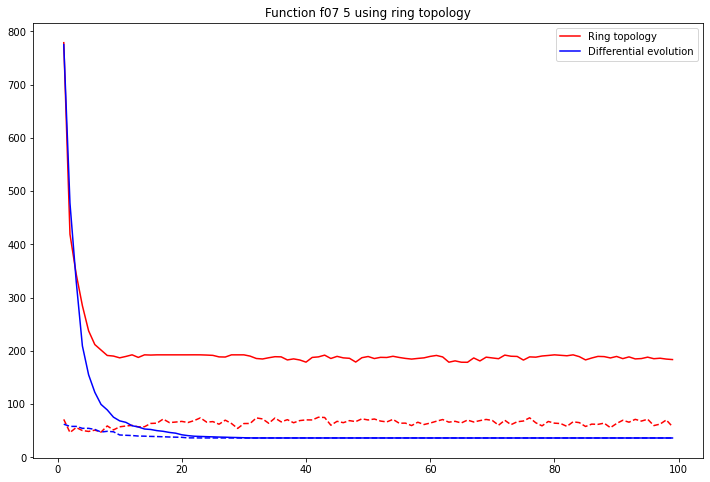

In [16]:
with fn.get_suite_wrapper(dimension=[2, 5], function_indices=[7]) as suite:
    for function in suite:  # type: cocoex.Problem
        populations, values = exe.execute_multiple(
            function,
            strategies.RingTopology.execute,
            initialization=strategies.RingTopology.init,
            show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)
        eva_population, eva_values = exe.execute_multiple(function,strategies.differential_evolution)

        plt.figure(figsize=(12,8))
        plt.title(f"Function f07 {function.dimension} using ring topology")
        plot.plot_aggregated(values, plot.popfn_median(), plot.aggfn_median(), label="Ring topology", c='r')
        plot.plot_aggregated(values, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='r')
        plot.plot_aggregated(eva_values, plot.popfn_median(), plot.aggfn_median(), label="Differential evolution", c='b')
        plot.plot_aggregated(eva_values, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='b')
        plt.legend()
        plt.show()

        if SHOW_GIFS and function.dimension == 2:
            gif = plot.animate_movement(function, populations[0], show_progress=True, title="Function f07 using ring topology")
            with open(os.path.join("main", "007.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/007.gif)")

The results are about 20 worse than following the best particle in the swarm. The reason (what I believe) is the information throughput is very small. In order to particle know about the better position, some of it's neighbors needs to reach it first - the neighbor can't tell it directly, even if it knows about it. Therefore, the behavior is more chaotic, and as we can see from the gif, the particles don't converge at all.

Now, let's try adaptive random topology.

In [17]:
definition = inspect.getsource(strategies.RandomTopology)
display.display(display.Markdown(f'```python\n{definition}\n```'))

```python
class RandomTopology:
    def __init__(self, lowerbound, upperbound, populationsize, dimension, velocity_lowerbound, velocity_upperbound):
        self.particles = np.random.uniform(lowerbound, upperbound, (populationsize, dimension))
        self.velocities = np.random.uniform(velocity_lowerbound, velocity_upperbound, (populationsize, dimension))
    def numpy(self):
        return self.particles
    def execute(self, values, *vars, w = 1 / (2 * np.log(2)), c = 0.5 + np.log(2), stepsize = 0.05, K=3):
        N = len(self.particles)
        neighbors = np.random.randint(0, N, (N, K))
        best_neighbor_indices = neighbors[range(N), np.argmin(values[neighbors], axis=1)]
        best_neighbor = self.particles[best_neighbor_indices]
        random_walk = np.random.normal(0, stepsize, self.velocities.shape)
        follow_best = np.random.uniform(0, c, len(self.particles))[:,np.newaxis] * (best_neighbor - self.particles)
        self.velocities = w * self.velocities + follow_best + random_walk
        self.particles = np.maximum(-5, np.minimum(5, self.particles + self.velocities))
        return self
    @staticmethod
    def init(lowerbound, upperbound, shape, velocity_lowerbound=0.1, velocity_upperbound=0.1):
        return RandomTopology(lowerbound, upperbound, shape[0], shape[1], velocity_lowerbound, velocity_upperbound)

```

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution
Best evaluation: 35.35000001179179


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Function f07 2 using adaptive random topology')

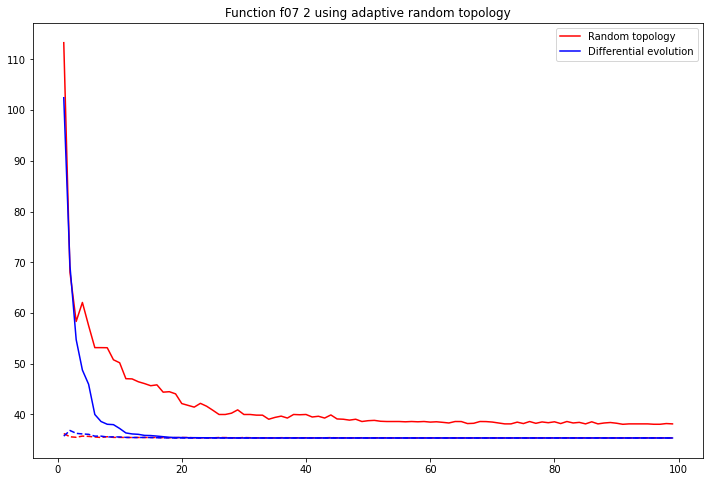

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution
Best evaluation: 35.63101201678665


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Function f07 5 using adaptive random topology')

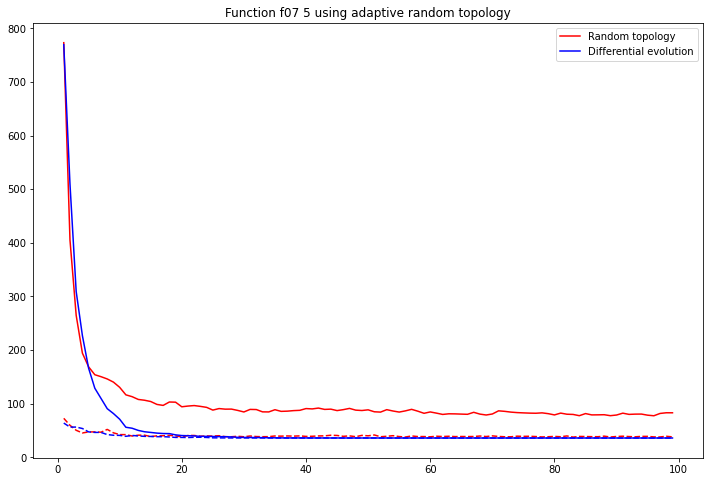

In [18]:
with fn.get_suite_wrapper(dimension=[2, 5], function_indices=[7]) as suite:
    for function in suite:  # type: cocoex.Problem
        populations, values = exe.execute_multiple(
            function,
            strategies.RandomTopology.execute,
            initialization=strategies.RandomTopology.init,
            show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)
        eva_population, eva_values = exe.execute_multiple(function,strategies.differential_evolution)

        plt.figure(figsize=(12,8))
        plt.title(f"Function f07 {function.dimension} using adaptive random topology")
        plot.plot_aggregated(values, plot.popfn_median(), plot.aggfn_median(), label="Random topology", c='r')
        plot.plot_aggregated(values, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='r')
        plot.plot_aggregated(eva_values, plot.popfn_median(), plot.aggfn_median(), label="Differential evolution", c='b')
        plot.plot_aggregated(eva_values, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='b')
        plt.legend()
        plt.show()

        if SHOW_GIFS and function.dimension == 2:
            gif = plot.animate_movement(function, populations[0], show_progress=True, title="Function f07 using adaptive random topology")
            with open(os.path.join("main", "008.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/008.gif)")

Using the same constants, the results are much better. There is higher probability that the particle would know about a better position much sooner, and therefore the swarm created cluster around the global optimum, although it seems quite hard to converge there. I believe it is caused by the random steps, as when I removed it, the algorithm performed better.

Note that the original reason for random steps was to add some randomness to the process. As we are picking up neighbors randomly this time, we don't need random steps anymore.

Finally, let's look at the nearest topology.

In [19]:
definition = inspect.getsource(strategies.NearestTopology)
display.display(display.Markdown(f'```python\n{definition}\n```'))

```python
class NearestTopology:
    def __init__(self, lowerbound, upperbound, populationsize, dimension, velocity_lowerbound, velocity_upperbound):
        self.particles = np.random.uniform(lowerbound, upperbound, (populationsize, dimension))
        self.velocities = np.random.uniform(velocity_lowerbound, velocity_upperbound, (populationsize, dimension))
    def numpy(self):
        return self.particles
    def execute(self, values, *vars, w = 1 / (2 * np.log(2)), c = 0.5 + np.log(2), stepsize = 0.05, K=3):
        N = len(self.particles)
        neighbors = np.zeros((N,K), dtype=int)
        for particle_i in range(N):
            distances = np.sqrt(np.sum((self.particles[particle_i][np.newaxis, :] - self.particles) ** 2, axis=1))
            closest = np.argsort(distances)[1:K+1]
            neighbors[particle_i] = closest
        best_neighbor_indices = neighbors[range(N), np.argmin(values[neighbors], axis=1)]
        best_neighbor = self.particles[best_neighbor_indices]
        random_walk = np.random.normal(0, stepsize, self.velocities.shape)
        follow_best = np.random.uniform(0, c, len(self.particles))[:,np.newaxis] * (best_neighbor - self.particles)
        self.velocities = w * self.velocities + random_walk + follow_best
        self.particles = np.maximum(-5, np.minimum(5, self.particles + self.velocities))
        return self
    @staticmethod
    def init(lowerbound, upperbound, shape, velocity_lowerbound=0.1, velocity_upperbound=0.1):
        return RandomTopology(lowerbound, upperbound, shape[0], shape[1], velocity_lowerbound, velocity_upperbound)

```

100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Found best solution
Best evaluation: 35.35000000008792


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Function f07 2 using nearest topology')

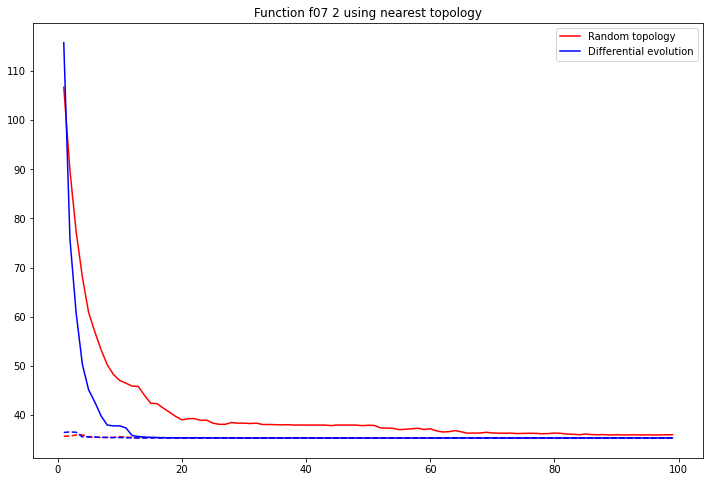

100% (10 of 10) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


Not found best solution
Best evaluation: 35.35957052325392


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Function f07 5 using nearest topology')

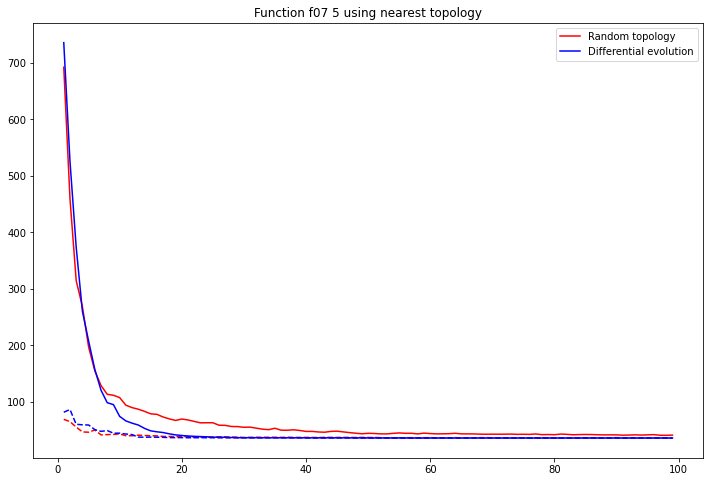

In [20]:
with fn.get_suite_wrapper(dimension=[2, 5], function_indices=[7]) as suite:
    for function in suite:  # type: cocoex.Problem
        populations, values = exe.execute_multiple(
            function,
            strategies.NearestTopology.execute,
            initialization=strategies.NearestTopology.init,
            show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)
        eva_population, eva_values = exe.execute_multiple(function,strategies.differential_evolution)

        plt.figure(figsize=(12,8))
        plt.title(f"Function f07 {function.dimension} using nearest topology")
        plot.plot_aggregated(values, plot.popfn_median(), plot.aggfn_median(), label="Random topology", c='r')
        plot.plot_aggregated(values, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='r')
        plot.plot_aggregated(eva_values, plot.popfn_median(), plot.aggfn_median(), label="Differential evolution", c='b')
        plot.plot_aggregated(eva_values, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='b')
        plt.legend()
        plt.show()

        if SHOW_GIFS and function.dimension == 2:
            gif = plot.animate_movement(function, populations[0], show_progress=True, title="Function f07 using ring topology")
            with open(os.path.join("main", "009.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/009.gif)")

Although the algorithm seems to perform quite well, from the movement gif is an apparent main disadvantage - particles can create clusters away from the optimum, where they support each other (as they are neighbors). This approach can easily converge to local optima only.

Let's see how would the approaches handle `f24` with many local optima.

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using ring topology
Best evaluation: 93.52858175616784


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using random topology
Best evaluation: 94.44659556960625


100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Not found best solution using nearest topology
Best evaluation: 93.48772397298774


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using differential evolution
Best evaluation: 94.44111911987837


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f24 instance 2 in 2D')

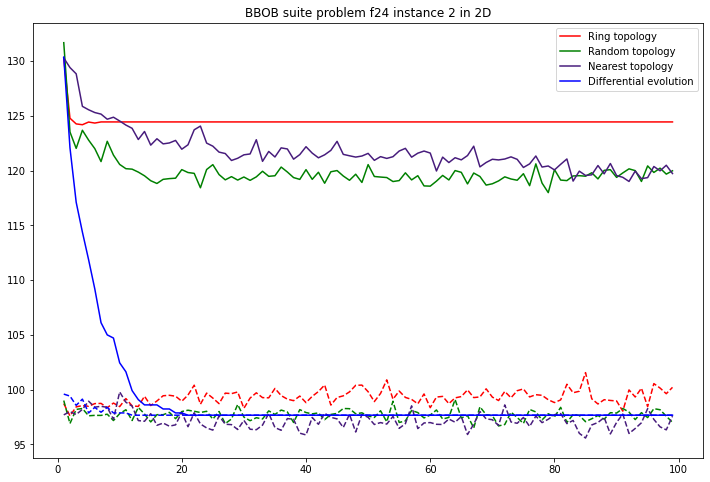

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using ring topology
Best evaluation: 119.85740948752236


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using random topology
Best evaluation: 108.78294420266649


100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Not found best solution using nearest topology
Best evaluation: 108.47196956461839


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using differential evolution
Best evaluation: 105.57999715031603


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f24 instance 2 in 5D')

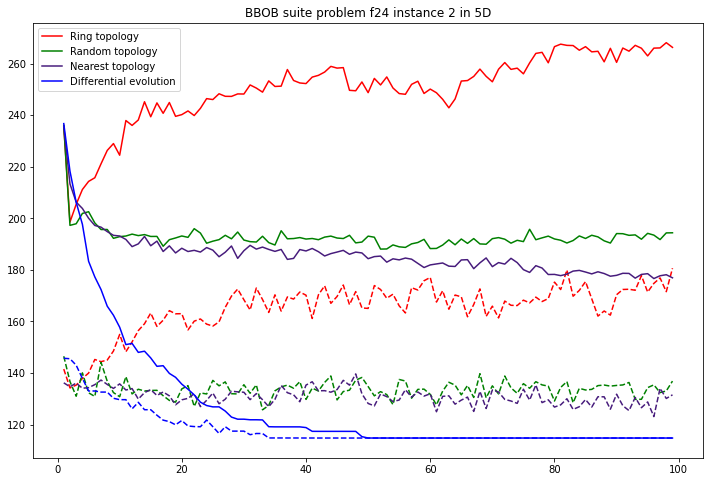

In [21]:
with fn.get_suite_wrapper(dimension=[2, 5], function_indices=[24]) as suite:
    for function_id in suite.ids():  # type: cocoex.Problem
        suite.reset(); function = suite.get_problem(function_id)
        pop_ring, val_ring = exe.execute_multiple(function,strategies.RingTopology.execute,initialization=strategies.RingTopology.init,show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution using ring topology", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)
        suite.reset(); function = suite.get_problem(function_id)
        pop_rand, val_rand = exe.execute_multiple(function,strategies.RandomTopology.execute,initialization=strategies.RandomTopology.init,show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution using random topology", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)
        suite.reset(); function = suite.get_problem(function_id)
        pop_near, val_near = exe.execute_multiple(function,strategies.NearestTopology.execute,initialization=strategies.NearestTopology.init,show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution using nearest topology", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)
        suite.reset(); function = suite.get_problem(function_id)
        pop_eva, val_eva = exe.execute_multiple(function,strategies.differential_evolution, show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution using differential evolution", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)

        plt.figure(figsize=(12,8));
        plt.title(function.name);
        plot.plot_aggregated(val_ring, plot.popfn_median(), plot.aggfn_median(), label="Ring topology", c='r')
        plot.plot_aggregated(val_ring, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='r')
        plot.plot_aggregated(val_rand, plot.popfn_median(), plot.aggfn_median(), label="Random topology", c='g')
        plot.plot_aggregated(val_rand, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='g')
        plot.plot_aggregated(val_near, plot.popfn_median(), plot.aggfn_median(), label="Nearest topology", c='#471c7c')
        plot.plot_aggregated(val_near, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='#471c7c')
        plot.plot_aggregated(val_eva, plot.popfn_median(), plot.aggfn_median(), label="Differential evolution", c='b')
        plot.plot_aggregated(val_eva, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='b')
        plt.legend();
        plt.show()

        if SHOW_GIFS and function.dimension == 2:
            gif = plot.animate_movement(function, pop_ring[0], show_progress=True, title="Function f24 using ring topology")
            with open(os.path.join("main", "010.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/010.gif)")
            gif = plot.animate_movement(function, pop_rand[0], show_progress=True, title="Function f24 using random topology")
            with open(os.path.join("main", "011.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/011.gif)")
            gif = plot.animate_movement(function, pop_near[0], show_progress=True, title="Function f24 using nearest topology")
            with open(os.path.join("main", "012.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/012.gif)")
            gif = plot.animate_movement(function, pop_eva[0], show_progress=True, title="Function f24 using differential evolution")
            with open(os.path.join("main", "013.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/013.gif)")

# Using memory - SPSO 2006

The problem with the approaches above were that the particles take into account the current state of the swarm only. Let's take, for example, a particle at a good spot, and it's neighborhood of very bad particles. Although all particles in the neighborhood have worse value than the current particle, it will try to move into the best position (although worse). That's not very fortunate, and with a small modification in the source code we could fix this issue, however, I will take a different approach and allow particles to remember best global position $b_g$ (best position obtained from other particles) and best local position $b_l$ (best position of the particle itself) over the whole evaluation.

This brings us to the algorithm `Standard2006` or *SPSO 2006* (Standard Particle Swarm Optimisation 2006) [[4]](#Bibliography). The purpose of this paper was to standardize different implementations of the Particle Swarm Optimization algorithms and mainly provide reference implementation that other algorithms can be compared with. The *SPSO 2006* algorithm is, in fact, the same algorithm that was proposed by the "Particle Swarm Optimisation" [[1]](#Bibliography) paper in 1995.

The implementation uses adaptive random topology, and the velocity update is

$$
v_i = w \cdot v_i + \text{Unif}(0,c)\cdot(b_g - p_i) + \text{Unif}(0,c)\cdot(b_l - p_i)
$$

Note that I removed the random step term, as the randomness in sampling from the uniform distribution is enough.

To follow the standard implementation, I changed the initialization of velocities to $v_i(0)=\frac{\text{Unif}(min, max) - p_i(0)}{2}$. The original paper also uses synchronous updates (looping over all the particles sequentially). I decided to implement the algorithm in an asynchronous manner - it better reflects our idea of "moving particles," and `numpy` library allows us to vectorize the instructions, so the improvement in performance is significant.

In [22]:
definition = inspect.getsource(strategies.Standard2006)
display.display(display.Markdown(f'```python\n{definition}\n```'))

```python
class Standard2006:
    def __init__(self, lowerbound: np.ndarray, upperbound: np.ndarray, population, dimension):
        self.population = np.random.uniform(lowerbound, upperbound, [population, dimension])
        self.lowerbound = lowerbound
        self.upperbound = upperbound
        self.initialized = False
        self.velocity = None
        self.best_pos = None
        self.best_val = None
        self.bestneigh_pos = None
        self.bestneigh_val = None

    def numpy(self):
        return self.population

    def execute(self, values: np.ndarray, function: cocoex.Problem,
                K: int = 3,
                w: float = 1 / (2 * np.log(2)),
                c: float = 0.5 + np.log(2)):
        if not self.initialized:
            self.velocity = (np.random.uniform(self.lowerbound, self.upperbound, self.population.shape) - self.population) / 2
            self.best_pos = self.population.copy()
            self.best_val = values.copy()
            self.bestneigh_pos = self.population.copy()
            self.bestneigh_val = values.copy()
            self.initialized = True

        # update best positions
        better_result = values < self.best_val
        self.best_val[better_result] = values[better_result]
        self.best_pos[better_result] = self.population[better_result]

        # inform other particles
        to_inform = np.random.choice(len(self.population), [K, len(self.population)])
        for neighbor in to_inform:
            to_update = values < self.bestneigh_val[neighbor]
            self.bestneigh_val[neighbor[to_update]] = values[to_update]
            self.bestneigh_pos[neighbor[to_update]] = self.population[to_update]

        # update velocity
        self.velocity = w * self.velocity + \
                        np.random.uniform(0, c, self.velocity.shape) * (self.best_pos - self.population) + \
                        np.random.uniform(0, c, self.velocity.shape) * (self.bestneigh_pos - self.population)

        # update positions
        self.population = self.population + self.velocity

        # confinement
        to_zero = np.logical_or(
            self.population < self.lowerbound[np.newaxis, :],
            self.population > self.upperbound[np.newaxis, :]
        )
        self.velocity[to_zero] = 0
        self.population = np.maximum(self.lowerbound, np.minimum(self.upperbound, self.population))
        return self

    @staticmethod
    def init(lowerbound: np.ndarray, upperbound: np.ndarray, shape:tuple):
        return Standard2006(lowerbound, upperbound, *shape)

```

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Found best solution
Best evaluation: 35.35000000000017


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f7 instance 2 in 2D')

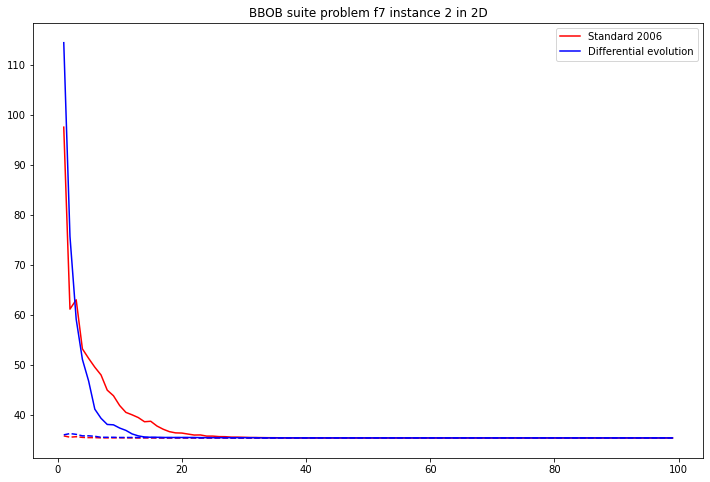

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution
Best evaluation: 93.43884480451753


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f24 instance 2 in 2D')

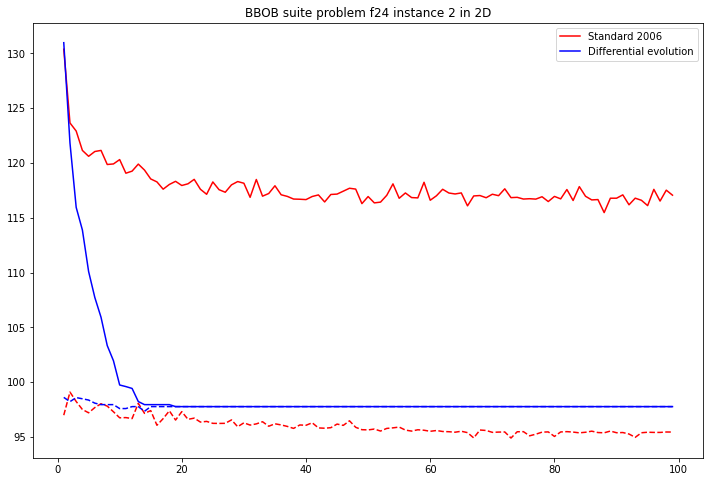

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Found best solution
Best evaluation: 35.350000000043096


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f7 instance 2 in 5D')

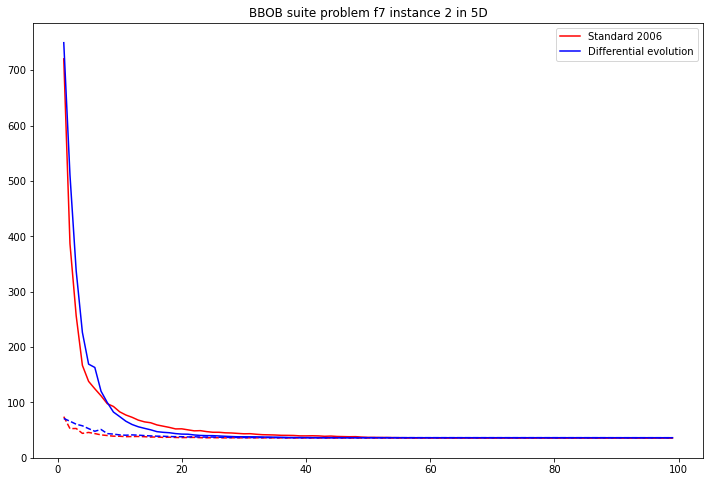

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution
Best evaluation: 101.5247962658065


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f24 instance 2 in 5D')

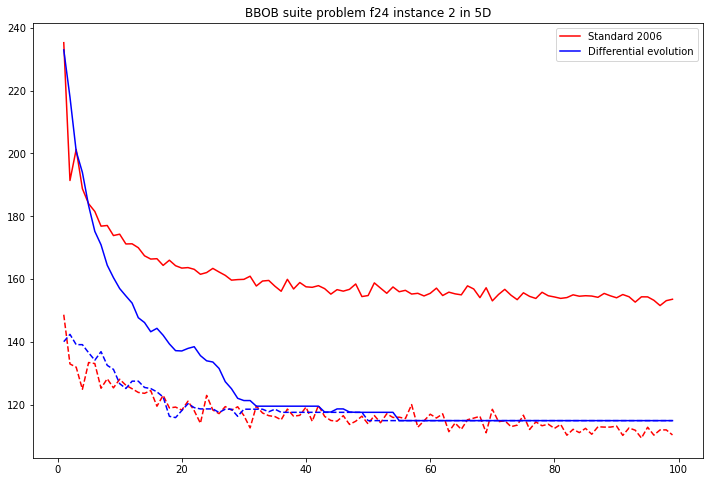

In [23]:
with fn.get_suite_wrapper(dimension=[2, 5], function_indices=[7, 24]) as suite:
    gif_counter = 14
    for function in suite:  # type: cocoex.Problem
        populations, values = exe.execute_multiple(
            function,
            strategies.Standard2006.execute,
            initialization=strategies.Standard2006.init,
            show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)
        eva_population, eva_values = exe.execute_multiple(function,strategies.differential_evolution)

        plt.figure(figsize=(12,8))
        plt.title(function.name)
        plot.plot_aggregated(values, plot.popfn_median(), plot.aggfn_median(), label="Standard 2006", c='r')
        plot.plot_aggregated(values, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='r')
        plot.plot_aggregated(eva_values, plot.popfn_median(), plot.aggfn_median(), label="Differential evolution", c='b')
        plot.plot_aggregated(eva_values, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='b')
        plt.legend()
        plt.show()

        if SHOW_GIFS and function.dimension == 2:
            gif = plot.animate_movement(function, populations[0], show_progress=True)
            with open(os.path.join("main", f"{gif_counter:03d}.gif"), "wb") as f:
                f.write(gif);
            display.Markdown(f"![img](main/{gif_counter:03d}.gif)")
            gif_counter = gif_counter + 1

We have finally better algorithm than differential evolution. Although the median of the standard 2006 algorithm is worse, at least some particles reach lower (i.e. better) values. The problem of differential evolution is that the individuals are "static" - when all individuals reach some region, there is no way to get out of it. That is not necessary true for the particles - even if they reach the best known optimum, they usually have some velocity left. That causes them to continue according to velocity and allows them to explore parameter space around. There is a very low probability that particle would stop moving.

Before moving on, there is *SPSO 2007* algorithm that adds just cosmetic updates to this algorithm. Mainly, its permutate the particles before each iteration (as it uses synchronous updates). I decided for asynchronous updates, so this change doesn't bother us. Another change is the usage of KISS pseudorandom generator - again something that doesn't bother me. Therefore I will not be talking about *SPSO 2007* anymore.

# SPSO 2011[[5]](#Bibliography)

So far, the velocity updates were done independently in each dimension. As a result, algorithms depend heavily on the coordinate system and perform worse on non-separable functions. The following image illustrates this phenomenon.

![asdf](pic/SPSO2006.png)
<center>Figure 1.a of "Standard Particle Swarm Optimisation 2011 at CEC-2013: A baseline for future PSO improvements"</center>

The gray rectangles represent the uniform distribution of all possible next positions. In particular, rectangles are aligned with axes. That is the main source of problems.

> In contrast, the latest Standard PSO exploits the idea of rotational invariance. For each particle and at each time step, a centre of gravity $G_i$ is defined around three points: the current position $p_i$, a point a little "beyond" the best previous personal position $b_l$, and a point a little "beyond" the best previous position in the neighborhood $b_g$. [[5]](#Bibliography)

$$
G_i = c\cdot\frac{b_g + b_l - 2\cdot p_i}{3} = \frac{c}{3}(b_g-p_i) + \frac{c}{3}(b_l-p_i)
$$

![asdf](pic/SPSO2011.png)
<center>Figure 1.b of "Standard Particle Swarm Optimisation 2011 at CEC-2013: A baseline for future PSO improvements"</center>

Algorithm then pick up random points $x'$ withing hypersphere with center in $G_i$ and radius $|G_i - p_i|$. As a result, this construction is invariant to rotation around center of the hypersphere. The velocity update is then as $v_i = w \cdot v_i + x'$.

In [24]:
definition = inspect.getsource(strategies.Standard2011)
display.display(display.Markdown(f'```python\n{definition}\n```'))

```python
class Standard2011:
    def __init__(self, lowerbound: np.ndarray, upperbound: np.ndarray, population, dimension):
        self.particles = np.random.uniform(lowerbound, upperbound, [population, dimension])
        self.lowerbound = lowerbound
        self.upperbound = upperbound
        self.initialized = False
        self.velocity = None
        self.best_pos = None
        self.best_val = None
        self.bestneigh_pos = None
        self.bestneigh_val = None

    def numpy(self):
        return self.particles

    def _sample_from_sphere(self, center, radius, shape):
        Y = np.random.normal(0, 1, shape)
        u = np.random.random(shape[0])
        r = radius * np.power(u, 1. / shape[1])
        norm = np.linalg.norm(Y, axis=1)
        x = (r/norm)[:, np.newaxis] * Y
        assert (np.linalg.norm(x, axis=1) <= radius).all()
        return x+center

    def execute(self, values: np.ndarray, function: cocoex.Problem,
                K: int = 3,
                w: float = 1 / (2 * np.log(2)),
                c: float = 0.5 + np.log(2)):
        if not self.initialized:
            self.velocity = (np.random.uniform(self.lowerbound, self.upperbound, self.particles.shape) - self.particles) / 2
            self.best_pos = self.particles.copy()
            self.best_val = values.copy()
            self.bestneigh_pos = self.particles.copy()
            self.bestneigh_val = values.copy()
            self.initialized = True

        # update best positions
        better_result = values < self.best_val
        self.best_val[better_result] = values[better_result]
        self.best_pos[better_result] = self.particles[better_result]

        # inform other particles
        to_inform = np.random.choice(len(self.particles), [K, len(self.particles)])
        for neighbor in to_inform:
            to_update = values < self.bestneigh_val[neighbor]
            self.bestneigh_val[neighbor[to_update]] = values[to_update]
            self.bestneigh_pos[neighbor[to_update]] = self.particles[to_update]

        # generate point in hypersphere
        bg = self.particles + np.random.uniform(0, c, self.particles.shape) * (self.bestneigh_pos - self.particles)
        bl = self.particles + np.random.uniform(0, c, self.particles.shape) * (self.best_pos - self.particles)
        G = (self.particles + bl + bg) / 3
        radius = np.linalg.norm(G - self.particles, axis=1)
        x_ = self._sample_from_sphere(G, radius, self.velocity.shape)

        # update velocity
        self.velocity = w * self.velocity + x_ - self.particles
        # udpate population
        self.particles = self.particles + self.velocity
        # confinement
        to_zero = np.logical_or(
            self.particles < self.lowerbound[np.newaxis, :],
            self.particles > self.upperbound[np.newaxis, :]
        )
        self.velocity[to_zero] = -0.5 * self.velocity[to_zero]
        self.particles = np.maximum(self.lowerbound, np.minimum(self.upperbound, self.particles))
        return self

    @staticmethod
    def init(lowerbound: np.ndarray, upperbound: np.ndarray, shape:tuple):
        return Standard2011(lowerbound, upperbound, *shape)

```

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Found best solution
Best evaluation: 35.35000000000008


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f7 instance 2 in 2D')

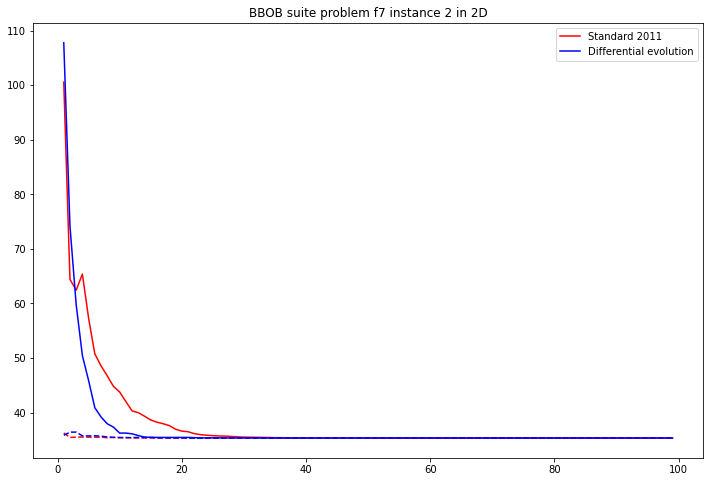

In [25]:
with fn.get_suite_wrapper(dimension=[2], function_indices=[7]) as suite:
    gif_counter = 14
    for function in suite:  # type: cocoex.Problem
        populations, values = exe.execute_multiple(
            function,
            strategies.Standard2011.execute,
            initialization=strategies.Standard2011.init,
            show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)
        eva_population, eva_values = exe.execute_multiple(function,strategies.differential_evolution)

        plt.figure(figsize=(12,8))
        plt.title(function.name)
        plot.plot_aggregated(values, plot.popfn_median(), plot.aggfn_median(), label="Standard 2011", c='r')
        plot.plot_aggregated(values, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='r')
        plot.plot_aggregated(eva_values, plot.popfn_median(), plot.aggfn_median(), label="Differential evolution", c='b')
        plot.plot_aggregated(eva_values, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='b')
        plt.legend()
        plt.show()

        if SHOW_GIFS and function.dimension == 2:
            gif = plot.animate_movement(function, populations[0], show_progress=True)
            with open(os.path.join("main", f"016.gif"), "wb") as f:
                f.write(gif);
            display.Markdown(f"![img](main/016.gif)")
            gif_counter = gif_counter + 1

Let's compare differential evolution, SPSO 2006 and SPSO 2011 algorithms on `f07` and `f24`.






Running BBOB suite problem f7 instance 2 in 2D


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Found best solution using differential evolution
Best evaluation: 35.35


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Found best solution using SPSO 2006
Best evaluation: 35.35000000000016


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Found best solution using SPSO 2011
Best evaluation: 35.35000000000016


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f7 instance 2 in 2D')

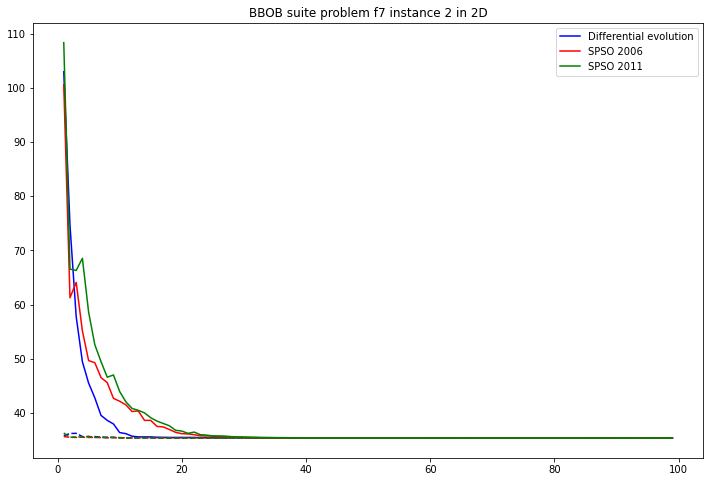






Running BBOB suite problem f24 instance 2 in 2D


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using differential evolution
Best evaluation: 94.53778146793593


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using SPSO 2006
Best evaluation: 93.31252931774952


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using SPSO 2011
Best evaluation: 93.33120235231513


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f24 instance 2 in 2D')

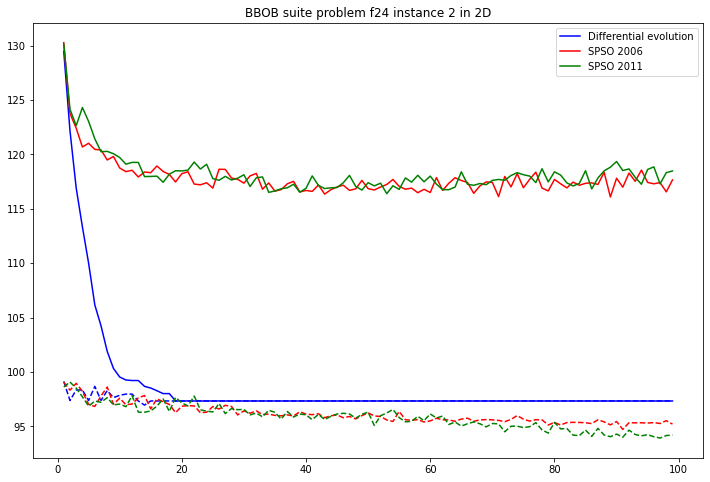






Running BBOB suite problem f7 instance 2 in 5D


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using differential evolution
Best evaluation: 35.48055305030515


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Found best solution using SPSO 2006
Best evaluation: 35.35000000019939


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using SPSO 2011
Best evaluation: 35.3500000208134


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f7 instance 2 in 5D')

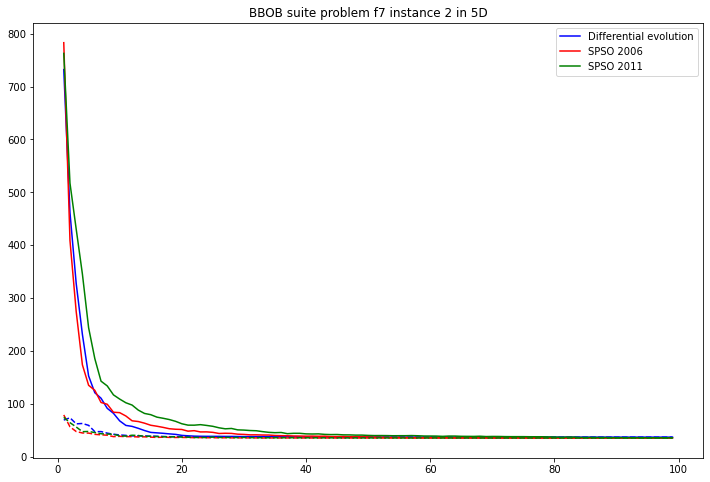






Running BBOB suite problem f24 instance 2 in 5D


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using differential evolution
Best evaluation: 105.60846425317274


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using SPSO 2006
Best evaluation: 101.33078388853629


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using SPSO 2011
Best evaluation: 100.74378005126127


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f24 instance 2 in 5D')

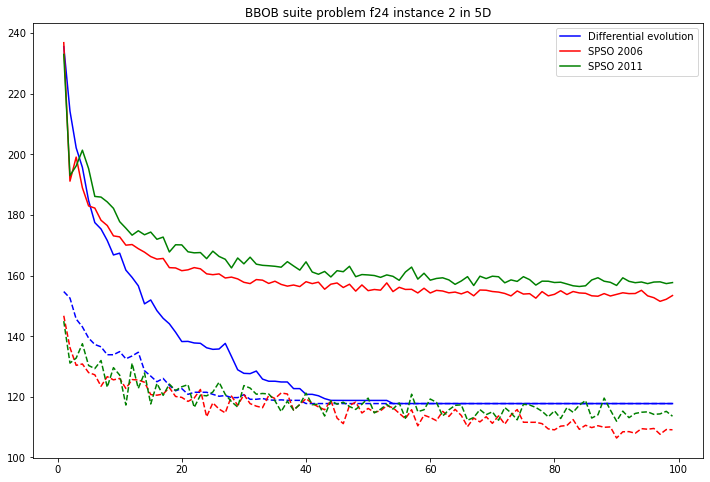






Running BBOB suite problem f7 instance 2 in 10D


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using differential evolution
Best evaluation: 39.00176512044328


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using SPSO 2006
Best evaluation: 35.428413514895865


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using SPSO 2011
Best evaluation: 35.50736256243876


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f7 instance 2 in 10D')

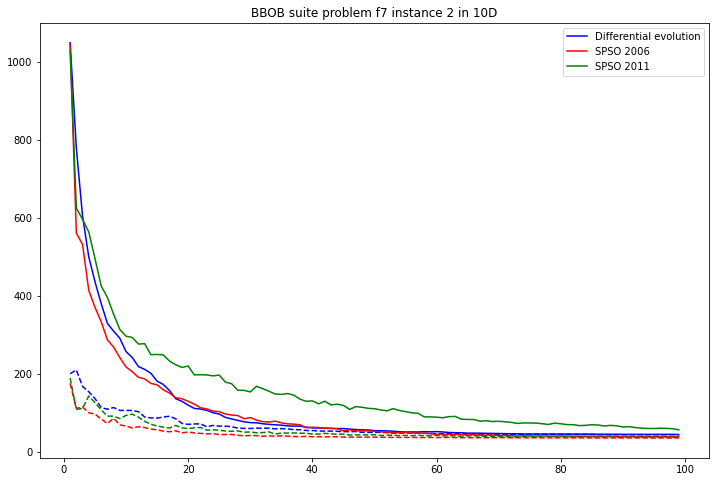






Running BBOB suite problem f24 instance 2 in 10D


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using differential evolution
Best evaluation: 134.54844369031733


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using SPSO 2006
Best evaluation: 124.89137468694496


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using SPSO 2011
Best evaluation: 129.11550177767234


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f24 instance 2 in 10D')

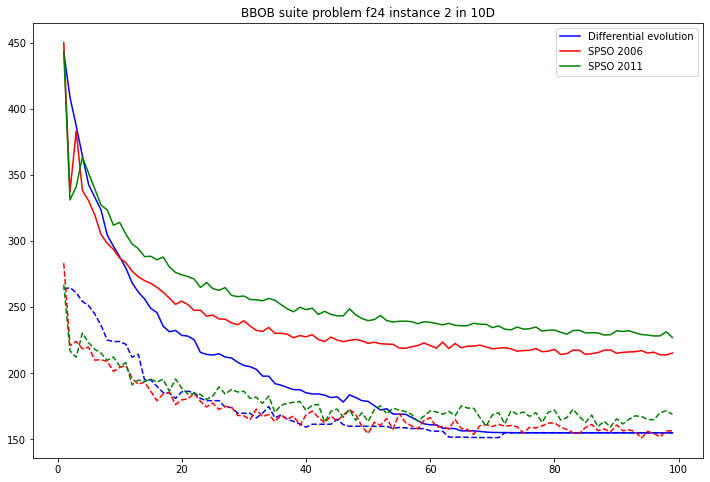

In [26]:
with fn.get_suite_wrapper(dimension=[2, 5, 10], function_indices=[7, 24]) as suite:
    gif_counter = 17
    for function_id in suite.ids():  # type: cocoex.Problem
        suite.reset(); function = suite.get_problem(function_id)
        print(f"\n\n\n\n\nRunning {function.name}", flush=True)
        pop_diff, val_diff = exe.execute_multiple(function,strategies.differential_evolution,show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution using differential evolution", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)
        suite.reset(); function = suite.get_problem(function_id)
        pop_2006, val_2006 = exe.execute_multiple(function,strategies.Standard2006.execute,initialization=strategies.Standard2006.init,show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution using SPSO 2006", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)
        suite.reset(); function = suite.get_problem(function_id)
        pop_2011, val_2011 = exe.execute_multiple(function,strategies.Standard2011.execute,initialization=strategies.Standard2011.init,show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution using SPSO 2011", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)

        plt.figure(figsize=(12,8));
        plt.title(function.name);
        plot.plot_aggregated(val_diff, plot.popfn_median(), plot.aggfn_median(), label="Differential evolution", c='b')
        plot.plot_aggregated(val_diff, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='b')
        plot.plot_aggregated(val_2006, plot.popfn_median(), plot.aggfn_median(), label="SPSO 2006", c='r')
        plot.plot_aggregated(val_2006, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='r')
        plot.plot_aggregated(val_2011, plot.popfn_median(), plot.aggfn_median(), label="SPSO 2011", c='g')
        plot.plot_aggregated(val_2011, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='g')
        plt.legend();
        plt.show()

        if SHOW_GIFS and function.dimension == 2:
            gif = plot.animate_movement(function, pop_diff[0], show_progress=True, title=f"Function {function.id_function}f using differential evolution")
            with open(os.path.join("main", f"{gif_counter:03d}.gif"), "wb") as f:
                f.write(gif);
            display.Markdown(f"![img](main/{gif_counter:03d}.gif)")
            gif = plot.animate_movement(function, pop_2006[0], show_progress=True, title=f"Function {function.id_function}f using SPSO 2006")
            with open(os.path.join("main", f"{gif_counter+1:03d}.gif"), "wb") as f:
                f.write(gif);
            display.Markdown(f"![img](main/{gif_counter+1:03d}.gif)")
            gif = plot.animate_movement(function, pop_2011[0], show_progress=True, title=f"Function {function.id_function}f using SPSO 2011")
            with open(os.path.join("main", f"{gif_counter+2:03d}.gif"), "wb") as f:
                f.write(gif);
            display.Markdown(f"![img](main/{gif_counter+2:03d}.gif)")
            gif_counter = gif_counter + 3

So far, the SPSO 2011 version seems worse than the SPSO 2006. However, don't forget that the SPSO 2011 isn't sensitive to the coordinate system, and as such, it's more general than the SPSO 2006. If you look at the evaluation on all functions (in the `complete` notebook), you can see that for some functions the SPSO 2011 is in fact better than SPSO 2006. However, I would expect to perform better on more functions. Also, I am not so sure about my implementation of the algorithm, and there can be bug (although I checked it three times). This would need further investigation.

In any case, it is obvious that the differential evolution can get easily stuck in the local optima - that is not the case for PSO, as we can see changes both in median and minimum over the whole run.

# Further improvements

There have been many improvements and papers on the way up to today. Some of the improvements are:

- Use different values $c$ for particle's best $c_{cog}$ sometimes called "cognitive factor" and for neighborhod best $c_{soc}$ sometimes called "social factor". This modification is quite often.
- Constraint velocity magnitude to maximum $V_{max}$ and sometimes even to minimum $V_{min}$ (allows to force exploration). It is possible to constrain even each scalar, then $V_{max}$ and $V_{min}$ would be vectors of dimension $D$.
- Adapt constants (i.e. $w, c_{cog}, c_{soc}, V_{max}, V_{min}$) dynamicly - their values may change each iteration.
- Use different constants for each particle.
- Use different topology - topologies may change only if a particle doesn't improve its value for Z steps, may use completely different topology that I introduced, and so on.
- Allow algorithm to self-adjust parameters.
- Use knowledge about the problem domain, for example use derivatives for continuous optimization.

# Fuzzy Self-Tuning PSO

Now I would like to introduce you "Fuzzy Self-Tuning PSO: A Settings-Free Algorithm for Global Optimization" [[7]](#Bibliography) paper from 2017. This algorithm uses all the improvements mentioned above except topology modification (it, in fact, uses adaptive random topology that we already used).

The main idea is to use fuzzy logic in order to optimize all the constants adaptively each iteration and independently for each particle. The idea of the authors is to use the algorithm as a black box as the algorithm is able to adjust all the parameters itself.

I will use the implementation from the author of the paper [fst-pso](https://github.com/aresio/fst-pso).






Running BBOB suite problem f7 instance 2 in 2D


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Found best solution using differential evolution
Best evaluation: 35.35000000000008


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Found best solution using SPSO 2011
Best evaluation: 35.35000000000019


100% (10 of 10) |########################| Elapsed Time: 0:00:49 Time:  0:00:49


Found best solution using FST-PSO
Best evaluation: 35.35000000000067


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f7 instance 2 in 2D')

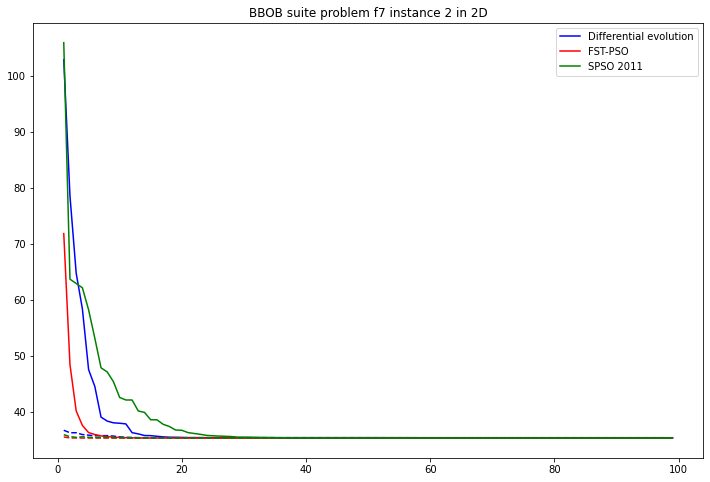






Running BBOB suite problem f24 instance 2 in 2D


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using differential evolution
Best evaluation: 94.95419005633356


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using SPSO 2011
Best evaluation: 93.40419712358354


100% (10 of 10) |########################| Elapsed Time: 0:00:51 Time:  0:00:51


Not found best solution using FST-PSO
Best evaluation: 93.30059397725975


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f24 instance 2 in 2D')

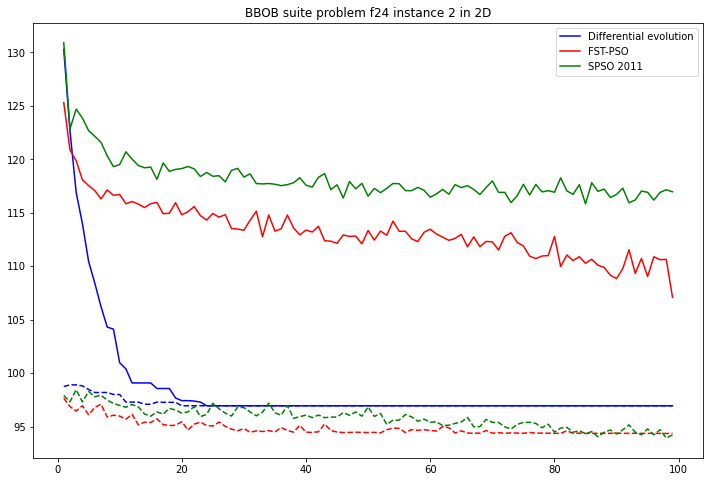






Running BBOB suite problem f7 instance 2 in 10D


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using differential evolution
Best evaluation: 38.49523990191109


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using SPSO 2011
Best evaluation: 36.31820335713723


100% (10 of 10) |########################| Elapsed Time: 0:00:55 Time:  0:00:55


Not found best solution using FST-PSO
Best evaluation: 35.83441701758889


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f7 instance 2 in 10D')

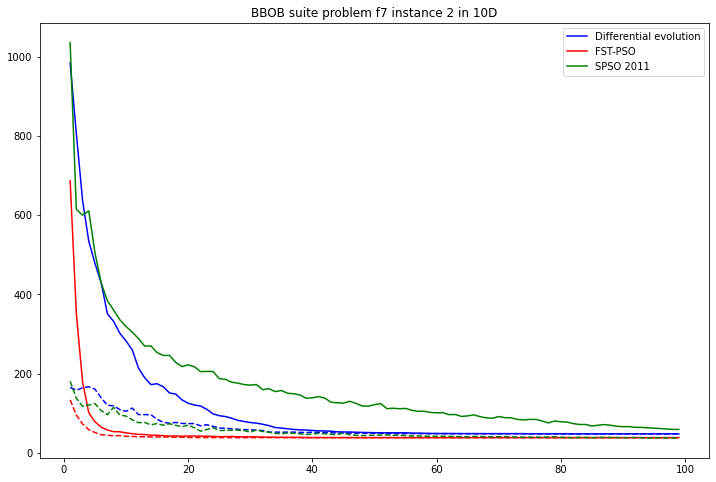






Running BBOB suite problem f24 instance 2 in 10D


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using differential evolution
Best evaluation: 142.5043552522071


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using SPSO 2011
Best evaluation: 134.56486425627213


100% (10 of 10) |########################| Elapsed Time: 0:00:56 Time:  0:00:56


Not found best solution using FST-PSO
Best evaluation: 105.17810116150496


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f24 instance 2 in 10D')

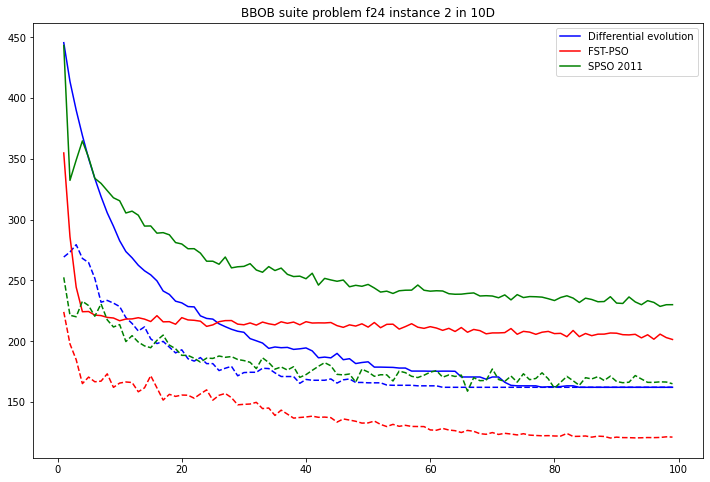






Running BBOB suite problem f7 instance 2 in 40D


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Not found best solution using differential evolution
Best evaluation: 146.94172265619287


100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Not found best solution using SPSO 2011
Best evaluation: 197.6020753130738


100% (10 of 10) |########################| Elapsed Time: 0:01:16 Time:  0:01:16


Not found best solution using FST-PSO
Best evaluation: 64.08375412044157


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f7 instance 2 in 40D')

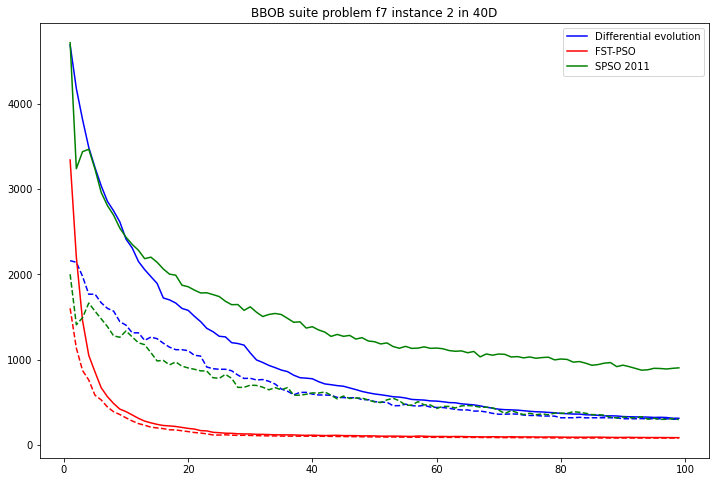






Running BBOB suite problem f24 instance 2 in 40D


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using differential evolution
Best evaluation: 535.0549592354477


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Not found best solution using SPSO 2011
Best evaluation: 536.8481666054381


100% (10 of 10) |########################| Elapsed Time: 0:01:11 Time:  0:01:11


Not found best solution using FST-PSO
Best evaluation: 348.03957255952764


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f24 instance 2 in 40D')

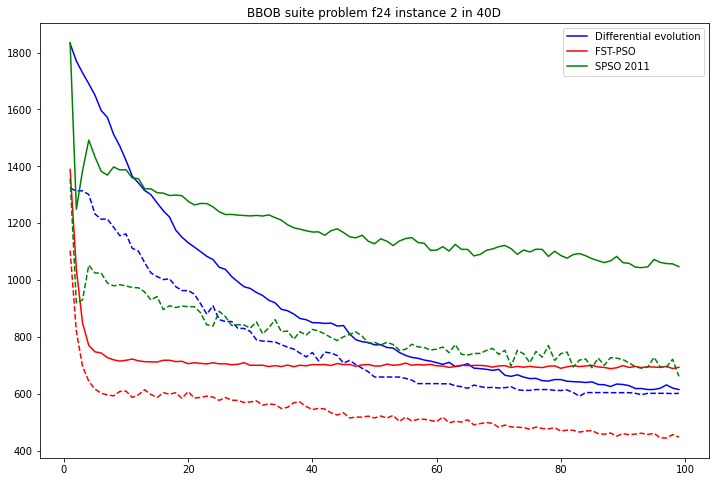

In [27]:
with fn.get_suite_wrapper(dimension=[2, 10, 40], function_indices=[7, 24]) as suite:
    gif_counter = 23
    for function_id in suite.ids():  # type: cocoex.Problem
        suite.reset(); function = suite.get_problem(function_id)
        print(f"\n\n\n\n\nRunning {function.name}", flush=True)
        pop_diff, val_diff = exe.execute_multiple(function,strategies.differential_evolution,show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution using differential evolution", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)
        suite.reset(); function = suite.get_problem(function_id)
        pop_2011, val_2011 = exe.execute_multiple(function,strategies.Standard2011.execute,initialization=strategies.Standard2011.init,show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution using SPSO 2011", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)
        suite.reset(); function = suite.get_problem(function_id)
        with io.capture_output() as captured:
            pop_fstpso, val_fstpso = exe.fstpso_multiple(function, show_progress=True);
        print(('Found' if function.final_target_hit else 'Not found') + " best solution using FST-PSO", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)
        suite.reset(); function = suite.get_problem(function_id)

        plt.figure(figsize=(12,8));
        plt.title(function.name);
        plot.plot_aggregated(val_diff, plot.popfn_median(), plot.aggfn_median(), label="Differential evolution", c='b')
        plot.plot_aggregated(val_diff, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='b')
        plot.plot_aggregated(val_fstpso, plot.popfn_median(), plot.aggfn_median(), label="FST-PSO", c='r')
        plot.plot_aggregated(val_fstpso, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='r')
        plot.plot_aggregated(val_2011, plot.popfn_median(), plot.aggfn_median(), label="SPSO 2011", c='g')
        plot.plot_aggregated(val_2011, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='g')
        plt.legend();
        plt.show()

        if SHOW_GIFS and function.dimension == 2:
            gif = plot.animate_movement(function, pop_2011[0], show_progress=True, title=f"Function {function.id_function}f using SPSO 2011")
            with open(os.path.join("main", f"{gif_counter:03d}.gif"), "wb") as f:
                f.write(gif);
            display.Markdown(f"![img](main/{gif_counter:03d}.gif)")
            gif = plot.animate_movement(function, pop_fstpso[0], show_progress=True, title=f"Function {function.id_function}f using FST-PSO")
            with open(os.path.join("main", f"{gif_counter+1:03d}.gif"), "wb") as f:
                f.write(gif);
            display.Markdown(f"![img](main/{gif_counter+1:03d}.gif)")
            gif_counter = gif_counter + 2

As seen from the graphs, the *FST-PSO* algorithm outperforms everything we tried so far. However, when we focus on the gif and movement of the particles, there is something odd about it. The particles don't look like living live behavior anymore (as was originally our idea).

Nevertheless, the *FST-PSO* algorithm is better for both functions `f07` and `f24`; doesn't matter the dimension. We once again returned to the state "computer know better what to do than human," and on this terrible disappointment, it's time to end.

*Last note: to be completely honest, if you check evaluation using all the function (in the `complete` notebook), you can notice that with enough generations the particle versions outperform the FST-PSO. The difference is however not that marginal and the FST-PSO converge much faster, thus need less function evaluations and in the context of continuous optimization benchmarks is better.*

# Further reading

If you want to know more about the Particle Swarm Optimisation, I would suggest "Particle swarm optimization algorithm: an overview" (2017) [[6]](#Bibliography) by Dongshu Wang, Dapei Tan and Lei Liu. They go through different aspects of PSO and provide a good overview of the evolution of the PSO.

# Bibliography

\[1\] J. Kennedy and R. Eberhart, "Particle swarm optimization," Proceedings of ICNN'95 - International Conference on Neural Networks, Perth, WA, Australia, 1995, pp. 1942-1948 vol.4.

\[2\] R. Storn, "On the usage of differential evolution for function optimization," Proceedings of North American Fuzzy Information Processing, Berkeley, CA, USA, 1996, pp. 519-523.

\[3\] Munoz-Zavala, Angel & Hernandez-Aguirre, Arturo & Villa Diharce, Enrique. (2009). The singly-linked ring topology for the particle swarm optimization algorithm. 65-72. 10.1145/1569901.1569911. 

\[4\] Maurice Clerc. Standard Particle Swarm Optimisation. 2012. ffhal-00764996

\[5\] Zambrano-Bigiarini, Mauricio & Clerc, Maurice & Rojas, Rodrigo. (2013). Standard Particle Swarm Optimisation 2011 at CEC-2013: A baseline for future PSO improvements. 2013 IEEE Congress on Evolutionary Computation, CEC 2013. 2337-2344. 10.1109/CEC.2013.6557848. 

\[6\] Wang, D., Tan, D. & Liu, L. Particle swarm optimization algorithm: an overview. Soft Comput 22, 387–408 (2018). https://doi.org/10.1007/s00500-016-2474-6

\[7\] Nobile, Marco & Cazzaniga, Paolo & Besozzi, Daniela & Colombo, Riccardo & Mauri, Giancarlo & Pasi, Gabriella. (2017). Fuzzy Self-Tuning PSO: A Settings-Free Algorithm for Global Optimization. Swarm and Evolutionary Computation. 39. 10.1016/j.swevo.2017.09.001. 